In [10]:
import sys

sys.path.insert(0, '/Volumes/data/LosAlamosSummer')
sys.path.insert(0, '/Volumes/data/LosAlamosSummer/DrOsborneCode')

import Utilities as ut
import importlib
import model as mod
import predict_with_uncertainty as pu
import custom as cus
importlib.reload(ut)
importlib.reload(mod)
importlib.reload(pu)
importlib.reload(cus)
import scipy
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

In [2]:
import pandas as pd

df = pd.read_excel ('/Volumes/data/LosAlamosSummer/Serializationstructures.xlsx')
print (df)
print(df.LWR)
SS=np.array(df.LWR[:-1])
print(SS)

            Sphere           LWR           SFR
0     2.615712e+02  1.000000e-03  1.000000e-03
1     5.737464e+02  6.865624e-03  6.865624e-03
2     8.888122e+02  9.160728e-03  9.160728e-03
3     1.195336e+03  1.107134e-02  1.107134e-02
4     1.481597e+03  1.273122e-02  1.273122e-02
...            ...           ...           ...
997   4.267269e+06  7.188363e+06  7.188363e+06
998   4.568146e+06  7.556836e+06  7.556836e+06
999   4.976225e+06  8.021766e+06  8.021766e+06
1000  5.607251e+06  8.701618e+06  8.701618e+06
1001  7.020693e+06           NaN           NaN

[1002 rows x 3 columns]
0       1.000000e-03
1       6.865624e-03
2       9.160728e-03
3       1.107134e-02
4       1.273122e-02
            ...     
997     7.188363e+06
998     7.556836e+06
999     8.021766e+06
1000    8.701618e+06
1001             NaN
Name: LWR, Length: 1002, dtype: float64
[1.00000000e-03 6.86562376e-03 9.16072825e-03 ... 7.55683605e+06
 8.02176620e+06 8.70161772e+06]


In [3]:
#datapath = '/Users/jessiejo/data/VBUDS/GroupStructurePaper/NeuralNetworks/All_Libraries/NewDataSetFull1.mat'
datapath='/Volumes/data/LosAlamosSummer/LWR/DATA/LWR_data_7.mat'
print('Loading In Data')
kinfBOL,kinfMOL,kinfEOL,GS=Utilities.LoadData(datapath,1)
#MakeGroupDensity(X, nDecades)
Nfeatures = 1000;
allData= Utilities.ProcessData(datapath, 1,1000,1,SS,1)
# allData: (100,000x1,000) y_direct: (100,000x3)
print('Finished Loading Data')

Loading In Data
Finished Loading Data


In [4]:
#!pip install -q -U keras-tuner
print(kinfBOL.shape)
print(len(kinfBOL))
kinf=np.array(np.zeros((len(kinfBOL),3)))
kinf[:,0]=kinfBOL
kinf[:,1]=kinfMOL
kinf[:,2]=kinfEOL#np.concatenate((kinfBOL,kinfMOL,kinfEOL),axis=0)
print(kinf.shape)

(49999,)
49999
(49999, 3)


In [5]:
Nsamples,Ndecades = allData.shape
vldF=.1
testF=.2
normConst=1#np.linalg.norm(kinf)
y_norm=np.array(kinf/normConst)

X, X_test, y, y_test, vldF_corr = Utilities.makeFractions(Nsamples, vldF, testF, allData, y_norm, 1)


NtrainingSamples = int(Nsamples*(1 - testF))
tranValSplit=int(NtrainingSamples*(1-vldF_corr))
X_train=X[:tranValSplit,:]
y_train=y[:,:tranValSplit]
X_val=X[tranValSplit+1:,:]
y_val=y[:,tranValSplit+1:]
print(y_test.shape)
print(y_val.shape)
print(y_norm.shape)
print(y_train.shape)

(3, 9999)
(3, 4999)
(49999, 3)
(3, 34999)


In [32]:
batch_size=267
model = tf.keras.Sequential([
    layers.Dense(764, activation='relu', name='hidden_1', input_dim=1000),
    layers.Dense(754, activation='relu',  name='hidden_2'),
    layers.Dense(3, activation='linear',name='output')])
model.compile(loss="mean_squared_logarithmic_error",optimizer=tf.keras.optimizers.Adam(6.108900863274014e-05),metrics="mean_squared_logarithmic_error")
model.build()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 764)               764764    
_________________________________________________________________
hidden_2 (Dense)             (None, 754)               576810    
_________________________________________________________________
output (Dense)               (None, 3)                 2265      
Total params: 1,343,839
Trainable params: 1,343,839
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(loss='mean_squared_logarithmic_error',optimizer=tf.keras.optimizers.Adam(1e-3))
model.fit(X_train,y_train.T, epochs=100, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())
model.compile(loss='mean_squared_logarithmic_error',optimizer=tf.keras.optimizers.Adam(1e-4))
model.fit(X_train,y_train.T, epochs=100, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())
model.compile(loss='mean_squared_logarithmic_error',optimizer=tf.keras.optimizers.Adam(1e-5))
model.fit(X_train,y_train.T, epochs=100, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())
model.compile(loss='mean_squared_logarithmic_error',optimizer=tf.keras.optimizers.Adam(1e-6))
model.fit(X_train,y_train.T, epochs=100, batch_size=batch_size, verbose=1,validation_data=(X_val,y_val.T), callbacks=cus.callbacks())

Epoch 1/100
132/132 [==============================] - 2s 13ms/step - loss: 0.0160 - val_loss: 0.0074
Epoch 2/100
132/132 [==============================] - 2s 13ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 3/100
132/132 [==============================] - 2s 13ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 4/100
132/132 [==============================] - 2s 13ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/100
132/132 [==============================] - 2s 12ms/step - loss: 9.5366e-04 - val_loss: 0.0014
Epoch 6/100
132/132 [==============================] - 2s 12ms/step - loss: 8.1726e-04 - val_loss: 9.8923e-04
Epoch 7/100
132/132 [==============================] - 1s 11ms/step - loss: 7.2498e-04 - val_loss: 0.0011
Epoch 8/100
132/132 [==============================] - 2s 12ms/step - loss: 6.4621e-04 - val_loss: 0.0012
Epoch 9/100
132/132 [==============================] - 2s 12ms/step - loss: 5.8040e-04 - val_loss: 9.1772e-04
Epoch 10/100
132/132 [==============================] 

Epoch 16/100
132/132 [==============================] - 2s 12ms/step - loss: 3.7597e-04 - val_loss: 8.8384e-04
Epoch 00016: early stopping


In [34]:
y_predicted = keff_model.predict(X_test)
metric = tf.keras.metrics.MeanSquaredError(name="mean_average_error", dtype=None)
metric.update_state(np.array(y_predicted*normConst),np.array(y_test.T*normConst))
metric.result().numpy()

1.0409348

In [35]:
from matplotlib import pyplot as plt
import numpy as np


(9999, 3)


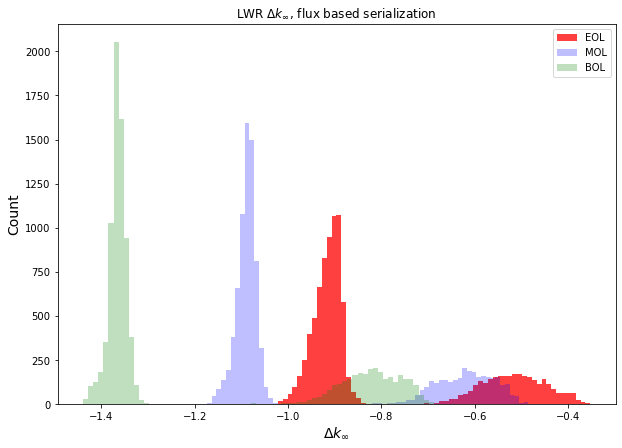

In [36]:
# Creating dataset
a = (y_predicted-y_test.T)
print(a.shape)
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(a[:,2],bins=70,alpha=0.75,label="EOL",color='r')
ax.hist(a[:,1],bins=70,alpha=0.25,label="MOL",color='b')
ax.hist(a[:,0],bins=70,alpha=0.25,label="BOL",color='g')
plt.xlabel("$Δk_{\infty}$", size=14)
plt.ylabel("Count", size=14)
plt.title("LWR $Δk_{\infty}$, flux based serialization")
plt.legend(loc='upper right')
plt.savefig("LWR_completeData_fluxShaped_wide_drO.png")
# Show plot
plt.show()


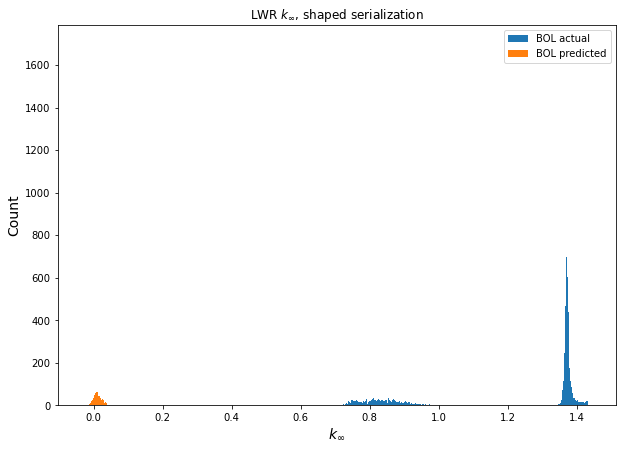

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
 

n_bins = 500
 

# Creating histogram
fig, axs = plt.subplots(figsize =(10, 7))
 
axs.hist(y_test.T[:,0], bins = n_bins,label="BOL actual")
axs.hist(y_predicted[:,0], bins = n_bins,label="BOL predicted")


plt.xlabel("$k_{\infty}$", size=14)
plt.ylabel("Count", size=14)
plt.legend(loc='upper right')

plt.title("LWR $k_{\infty}$, shaped serialization")
plt.savefig("kinfPredDist_fluxShaped_wide_drO.png",bbox_inches ="tight",
            pad_inches = 1,
            transparent = False,
            facecolor ="w",
            edgecolor ='w',
            orientation ='landscape')

plt.show()
# Show plot



In [38]:

print(np.std(a[:,2]))
print(np.std(a[:,1]))
print(np.std(a[:,0]))

0.18918583694629387
0.21835144690249306
0.251845114070759
